#  Подсчет показателя инсуляции insulation score

Автор: Александра Галицына, agalitzina@gmail.com

Этот ноутбук предназначен для чтения файлов диктиостелиума в формате hdf5 и подсчета показателя инсуляции по ним. 

Ноутбук написан для Python2, но может быть перенесен на Python3. Необходимые пакеты: hiclib, mirnylib, h5py и другие довольно распространенные вроде numpy, pickle, matplotlib.

На вход ноутбуку требуются файлы в формате .hdf5 с некорректированными данными Hi-C дикти, а также папка с геномом дикти. 

hdf5 файл с некорректированными (=сырыми) данными Hi-C содержит в себе теплокарту взаимодействий всех хромосом ("heatmap"), а также информацию про хромосомы. 
Геном нужен только по формальным причинам и особенностям работы hiclib (библиотека требует знание длин хромосом не только из файлов hdf5, но и из самого генома). В остальном можно обойтись без него. 



Процедура коррекции -- может быть нетривиальна для перенесения в C++, поэтому в папке с данным кодом расположены также корректированные файлы IC-\*.hdf5. Эти файлы были процессированы hiclib и итеративно корректированны (iterative correction), в них формат данных немного отличается от того, который есть в сырых данных. 
В этих файлах взаимодействия разбиты по отдельным хромосомам, а хромосомам отвечают цифры, например: 

Под ключом 'genomeIdxToLabel' можно найти соответствие между номером и названием хромосомы. К сожалению, там какой-то компрессированный формат данных, который считывается pickle, а как иначе привести его в вид читаемого словаря -- не знаю.

'0 0' -- числовая матрица со взаимодействиями хромосомы с индексом 0 с самой собой, '0 1' -- нулевой с первой и так далее. 


Дальнейший код написан для формата сырых данных Hi-C (т.е. когда вместо многих матриц одна общая heatmap, в которой подряд идут все хромосомы).

In [1]:
# importing required libraries, some of them might not be needed

from __future__ import division, print_function # if python2

from hiclib.binnedData import *  # library to read and manipulate hdf5 files with Hi-C data
from mirnylib import genome # library to read the genome info

#data manipulation libs
import h5py
import numpy as np
import pandas as pd
import scipy
import pickle

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axis3d import Axis
%matplotlib inline

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# functions that calculate insulation score

def calculate_insulation(mtx, sq, dist):
    """
    Calculates insultion for one particular distance and square size
    """
    vect = []
    full = []
    for i in range(len(mtx)):
        bgn_x = i + dist
        end_x = bgn_x + sq 
        if bgn_x > len(mtx): bgn_x = len(mtx)
        if end_x > len(mtx): end_x = len(mtx) 
            
        end_y = i - dist + 1
        bgn_y = end_y - sq
        if end_y<0: end_y = 0
        if bgn_y<0: bgn_y = 0
        
        if  bgn_x + sq > len(mtx) or end_y-sq < 0:
            full.append(0)
            vect.append(np.nan)
        else:
            full.append(1)
            vect.append( np.mean(mtx[bgn_y:end_y, bgn_x:end_x]) )
    
    return(vect, full) 

def norm_func(x):
    """
    Normalization function for insulation calculation
    """
    ret = np.log2(x/np.mean(x))
    ret[np.isinf(ret)] = np.nan
    return ret

def calculate_insulation_multi(mtx_tmp, square_size, distance, 
                               func=calculate_insulation, 
                               norm_func=norm_func):
    """
    Calculates insulation for a range of parameters and returns as 2D matrix.
    Note that either square or distance should be an array, but not both of them.
    """
    if isinstance(square_size, list) or isinstance(square_size, np.ndarray):
        vs = [ func(mtx_tmp, sq=x, dist=distance) for x in square_size]
    elif isinstance(distance, list) or isinstance(distance, np.ndarray):    
        vs = [ func(mtx_tmp, sq=square_size, dist=x) for x in distance]
    else:
        raise Exception('Check square_size and distance, one of them should be array (list or numpy)')

    #return vs
    new = []
    for i in range(len(vs)):

        val  = np.array(vs[i][0])
        mask = np.isfinite(vs[i][0])

        val[mask] = norm_func(val[mask])
        new.append(val)
        
    new = np.array(new)
    new[np.isinf(new)]=np.nan

    return new

def plot_insulation(rng_mtx, mtx_new, df_tad='', ch='', title=None, res=20000, vmax=1, figsize=(25,5.5)):
    
    plt.figure(figsize=figsize)  # Задаем размер
    sns.heatmap(mtx_new[:,rng_mtx[0]:rng_mtx[1]], 
                cmap="RdBu_r",  # Цветовая шкала
                center=0,   # значение матрицы, в котором будет центр цветовой шкалы
                vmax=vmax,  # самый красный цвет
                vmin=-vmax, # самый синий цвет
                cbar=False) # прячем colorbar
    plt.yticks([]) # По умолчению ставятся подписи шкалы оси OY, убираем ее.
    
    arng = np.arange(0,rng_mtx[1]-rng_mtx[0], 5)
    plt.xticks(arng+0.5, ["{} Kb".format(x) if x//1000==0 else "{:.0f} Mb".format(x/1000) for x in(rng_mtx[0]+arng)*res], rotation=90)  # Хорошо подписываем ось OX с геномными координатами
    
    plt.title(title)
    
    print('')
    
    return(None)

In [3]:
# Loading genome info, it might not be required
fasta_path        = './DICTY_FASTA/' # Path to genome folder
chrms             = ['1', '2', '3', '4', '5', '6']
genome_db = genome.Genome(fasta_path, readChrms=chrms)


# The resolution can be 3 Kb = 3000 bp, 20 Kb = 20000 bp (basepairs) and so on
res = 5000 # setting resolution -- the size in bp of one bin of matrix

# loading the data
a = h5py.File('./heatmap-5K.hdf5', 'r') # path to heatmap file in hdf5 format
mtx_total = a['heatmap'].value

chr_idx2lab = pickle.loads(a['genomeIdxToLabel'].value)
order = [chr_idx2lab[i] for i in range(len(chr_idx2lab.keys()))]

data = binnedDataAnalysis(resolution=res, genome=genome_db)
data.simpleLoad(mtx_total, 'dicty', chromosomeOrder=order)

total_length = len(mtx_total)
ch_lens = a['chromosomeStarts'].value
ch_lens = np.append(ch_lens, total_length)

# Some parts of dataset are bad, we would like to mask them
data.dataDict['dicty'][355:360, :] = 0
data.dataDict['dicty'][:, 355:360] = 0
data.dataDict['dicty'][0:40, :] = 0
data.dataDict['dicty'][:, 0:40] = 0

________________________________________________________________________________
[Memory] Calling mirnylib.genome.run_func...
run_func(['1', '2', '3', '4', '5', '6'], 'gap.txt', 'chr%s.fa', '_getChrmLen', 'DICTY_FASTA')
_________________________________________________________run_func - 2.2s, 0.0min
________________________________________________________________________________
[Memory] Calling mirnylib.genome.run_func...
run_func(['1', '2', '3', '4', '5', '6'], 'gap.txt', 'chr%s.fa', '_getGCBin', 'DICTY_FASTA', 5000)
_________________________________________________________run_func - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling mirnylib.genome.run_func...
run_func(['1', '2', '3', '4', '5', '6'], 'gap.txt', 'chr%s.fa', '_getUnmappedBasesBin', 'DICTY_FASTA', 5000)
_________________________________________________________run_func - 0.2s, 0.0min
No SS reads found


In [5]:
N = len(data.dataDict['dicty'])

# iterative correction
data.removeDiagonal()
data.removePoorRegions()
data.iterativeCorrectWithoutSS()
    
# insulation calculation for two modes: 
# varying square side (expanding) or
# distance from the diagonal (sliding)

# creating arrays for being filled with IS values, the total length of chromosomes is required,
# 100 is the number of each parameter we want to test
insulation_slide_total = np.zeros([100, total_length])
insulation_expand_total = np.zeros([100, total_length])

# Calculation of IS, iterating through chromosomes:
for i in chr_idx2lab.keys():
    
    ch = 'chr'+chr_idx2lab[i]
    print(ch)

    # Since all chromosomes are ordered and "concatenated" in dataset, we need to select only
    # inter-chromosomal interactions
    
    ch_end = ch_lens[i+1]
    ch_bgn = ch_lens[i]
    
    mtx = data.dataDict['dicty'][ch_bgn:ch_end, ch_bgn:ch_end]
    insulation_slide = calculate_insulation_multi(mtx, 
                                                square_size=5, 
                                                distance=np.arange(0, 100, 1), 
                                                norm_func=norm_func)
    insulation_expand = calculate_insulation_multi(mtx, 
                                                square_size=np.arange(1, 101, 1), 
                                                distance=1, 
                                                norm_func=norm_func)    
    
    insulation_slide_total[:, ch_bgn:ch_end]  = insulation_slide
    insulation_expand_total[:, ch_bgn:ch_end] = insulation_expand

removed 133 poor bins


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/mirnylib/numutils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(inObject, np.complex):
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/mirnylib/numutils.py:57: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(inObject, np.float):


Got floating-point array for correction. Rows with                     5 least entrees are: [93 94 94 95 95]
Hi


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/hiclib/binnedData.py:283: UserWarning: 
Iterative correction might lead to about                     10 % relative error for certain columns
  %d %% relative error for certain columns" % error)


chr1


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2


chr2
chr3
chr4
chr5
chr6


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


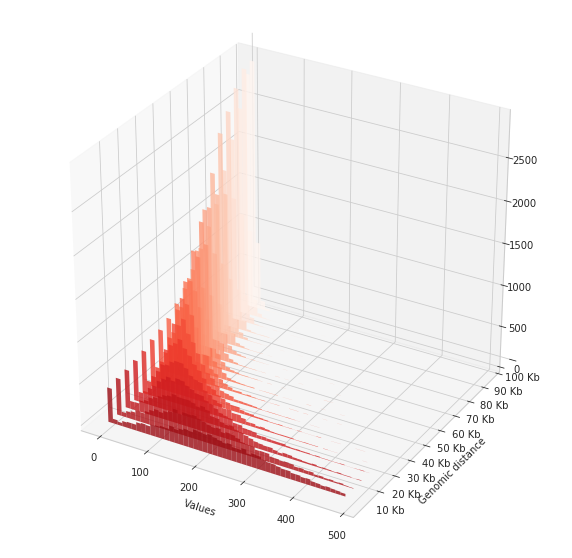

In [6]:
d = 500
step=10

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d') 
for z in range(2,20):
    diag = mtx_total.diagonal(z)
    counts, bins = np.histogram(diag, bins=np.arange(0,d,step))
    xs = bins[:-1]
    ys = counts
    c = mpl.cm.get_cmap('Reds_r', 20)(z)
    ax.bar(xs, ys, zs=z, zdir='y', color=c, alpha=0.8, width=step)
ax.set_xlabel('Values')
ax.set_ylabel('Genomic distance')
ax.set_yticks(2+np.arange(2,21,2))
ax.set_yticklabels(["{} Kb".format(x) if x//1000==0 else "{:.1f} Mb".format(x/1000) for x in np.arange(2,21,2)*res//1000])
ax.set_zlabel('')

fig.show()

In [7]:
ch_lens

array([   0,  985, 2682, 3954, 5045, 6071, 6792])

In [8]:
rng = [2682+100,2682+450]

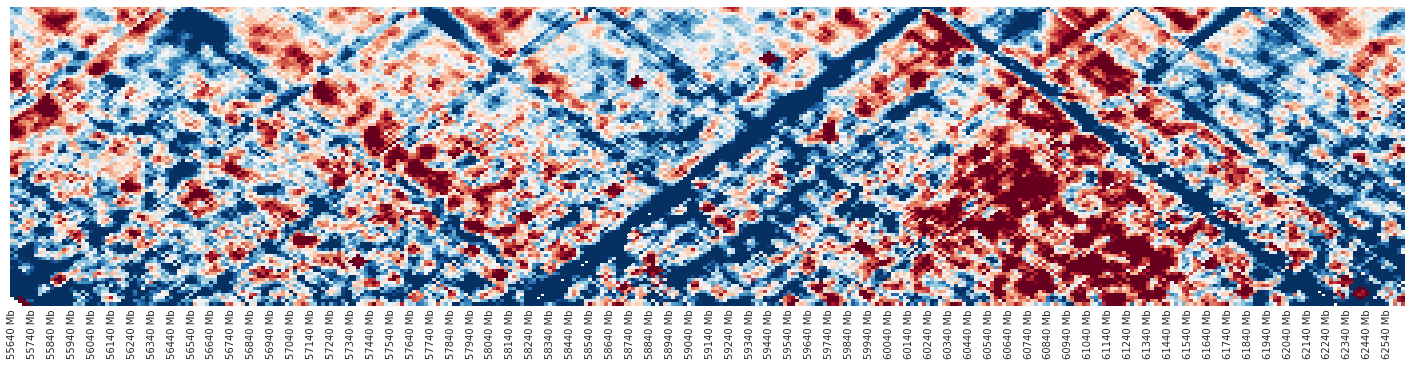

In [9]:
plot_insulation(rng, insulation_slide_total, vmax=0.5, figsize=(25,5.5), title='')

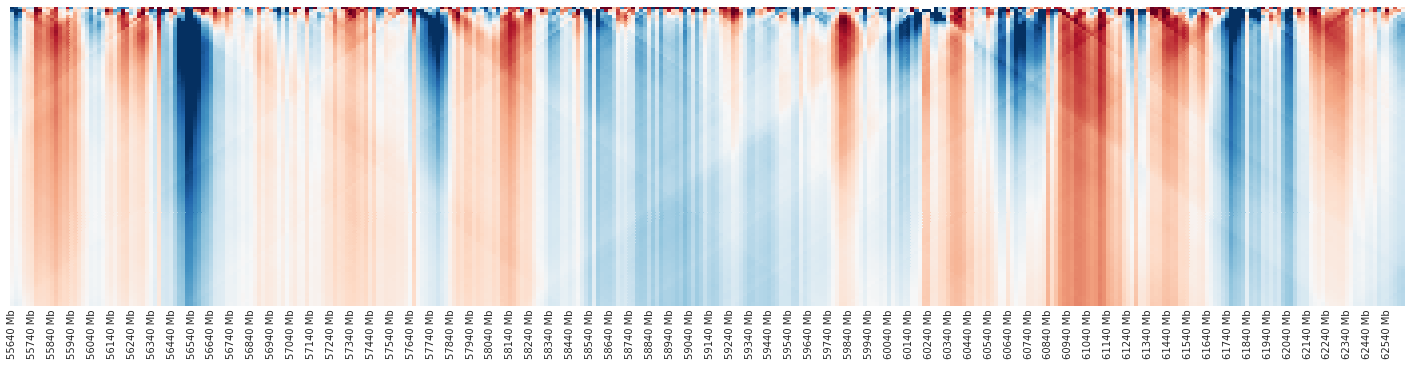

In [11]:
plot_insulation(rng, insulation_expand_total, vmax=0.5, figsize=(25,5.5), title='')